# Missteering measurement using AC dipole excitation

- Just horizontal kicks
- TFB was off in these measurements

In [128]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.07.02
Your IP is 172.17.0.16
2018-07-09 14:07:50


---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [129]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [130]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [131]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 215 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.16.19.35.398.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.20.32.16.081.mat


In [132]:
df1 = myToolbox.fromMatlabToDataFrame(files[81:91],matlabVars,verbose=False)
df1['label'] = 'ACD@C500'
# df2 = myToolbox.fromMatlabToDataFrame(files[117:134],matlabVars,verbose=False)
# df2['label'] = 'ACD@C200_2'
# df3 = myToolbox.fromMatlabToDataFrame(files[135:150],matlabVars,verbose=False)
# df3['label'] = 'C265Reference'
# df4 = myToolbox.fromMatlabToDataFrame(files[151:166],matlabVars,verbose=False)
# df4['label'] = 'ACD@C300'
# df5 = myToolbox.fromMatlabToDataFrame(files[176:192],matlabVars,verbose=False)
# df5['label'] = 'C400Reference'
# df6 = myToolbox.fromMatlabToDataFrame(files[192:],matlabVars,verbose=False)
# df6['label'] = 'C300Reference'

In [133]:
# myDataFrame = pnd.concat([df1,df2,df3,df4,df5,df6])
myDataFrame = df1

# Data cleanup

In [134]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-07-02 18:36:10.300000'].name) # non-phys emittance

Dropped 1 duplicate(s)
---
BPM data ok
---


# Import the optics model

In [135]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Match the tomogram data

In [136]:
myDataFrame['deltaP_P_rms'] = 0.83e-3
myDataFrame['beta'] = 0.915095
myDataFrame['gamma'] =  2.479919

# Intensity

In [137]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.concatenate((np.zeros(100,dtype=float),x))) # start the acquisition from 0 ms

# Save the imported data

In [138]:
myDataFrame.to_pickle('imported_data_2018.07.02_vertical.pkl')

In [139]:
# myDataFrame=pnd.read_pickle('imported_data_2018.07.02_vertical.pkl')

# Losses ACD induced

37.450202/37.4502
Losses 0.00 %


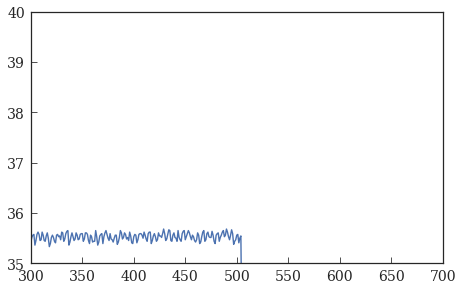

In [170]:
# what losses estimation does
plt.plot(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C500'].values[2])
I0 = np.mean(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C500'].values[0][460:465])
I1 = np.mean(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C500'].values[0][600:605])
print(str(I0)+'/'+str(I1))
print('Losses %.2f'%(100*(1-I1/I0))+' %')
plt.xlim(300,700);
plt.ylim(35,40);

In [171]:
myDataFrame['ACD Losses %'] = 0.

# process the various acquisitions
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'ACD@C500'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C500'].apply(lambda x: 100*(1-np.mean(x[600:605]) / np.mean(x[460:465])))   


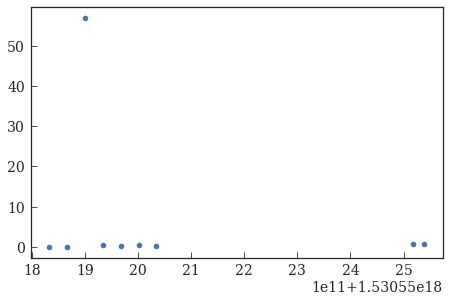

In [172]:
plt.plot(myDataFrame['ACD Losses %'],'o')

In [174]:
# limit the data to losses < 1%
myDataFrame = myDataFrame.loc[myDataFrame['ACD Losses %'] < 1.]
len(myDataFrame)

8

# Calculate wire scanner emittance
## X plane
### Traditional method

In [175]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


In [176]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Y plane

In [177]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [178]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

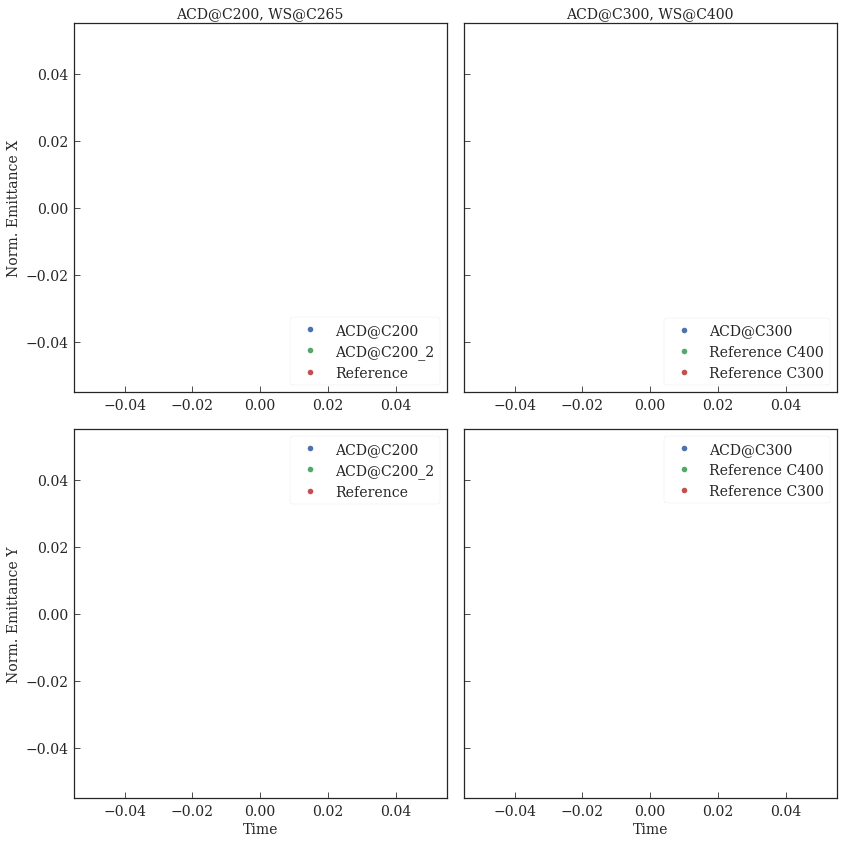

In [179]:
fig, ax = plt.subplots(2,2,figsize=(12,12), sharey=True)

# ACD@C200
emiC200 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200']
ax[0,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[0,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference']
ax[0,0].plot(refC265,'o',label = 'Reference')

ax[0,0].set_title('ACD@C200, WS@C265')
ax[0,0].set_ylabel('Norm. Emittance X')
ax[0,0].legend(frameon=True,loc=4)

emiC200 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200']
ax[1,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[1,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference']
ax[1,0].plot(refC265,'o',label = 'Reference')

ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Norm. Emittance Y')
ax[1,0].legend(frameon=True)


# ACD@C300
emiC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300']
ax[0,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference']
ax[0,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference']
ax[0,1].plot(refC300,'o',label = 'Reference C300')

ax[0,1].set_title('ACD@C300, WS@C400')
ax[0,1].legend(frameon=True,loc=4)

emiC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300']
ax[1,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference']
ax[1,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference']
ax[1,1].plot(refC300,'o',label = 'Reference C300')

ax[1,1].set_xlabel('Time')
ax[1,1].legend(frameon=True)


fig.tight_layout()
plt.savefig('emi_all.eps', format='eps', dpi=100)

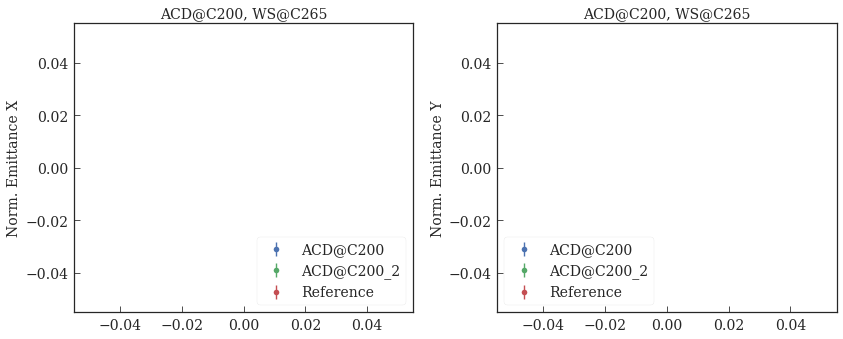

In [180]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[0].set_title('ACD@C200, WS@C265')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[1].set_title('ACD@C200, WS@C265')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True,loc=3)

fig.tight_layout()
plt.savefig('emi_ACD@C200.eps', format='eps', dpi=100)

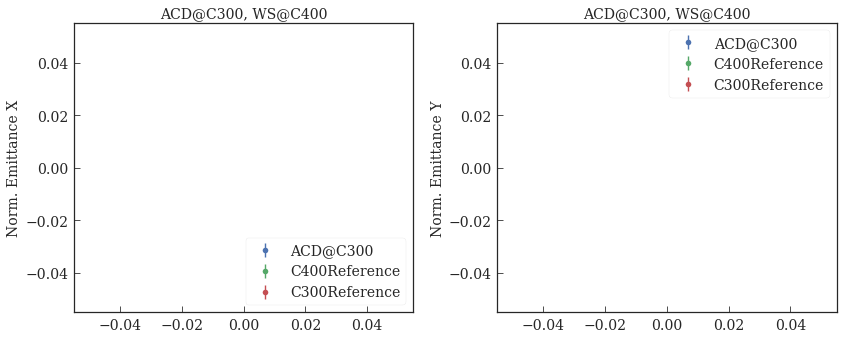

In [181]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[0].set_title('ACD@C300, WS@C400')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[1].set_title('ACD@C300, WS@C400')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True)

fig.tight_layout()
plt.savefig('emi_ACD@C300.eps', format='eps', dpi=100)

# BPMs

In [182]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,:])
myDataFrame['BPMy'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,:])

In [183]:
len(myDataFrame)

8

2018-07-02 17:18:53.500000


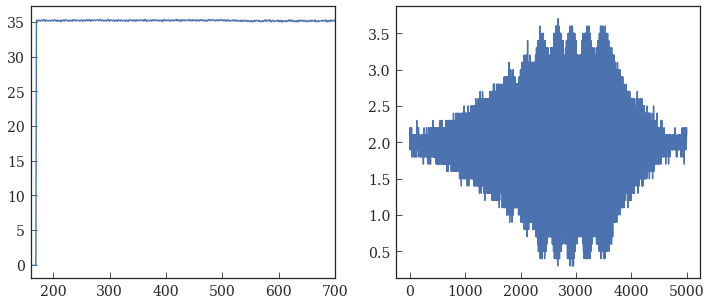

In [184]:
k=2

print(myDataFrame.iloc[k].name)
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(myDataFrame['Intensity'].iloc[k])
ax[0].set_xlim(160,700)
ax[1].plot(myDataFrame['BPMy'].iloc[k][1,:])

In [192]:
# calculate the max oscillation amplitude from the mean value at BPM03
myDataFrame['Max amplitude X'] = myDataFrame['BPMx'].apply(lambda x: np.max(x[1,:])-np.mean(x[1,:]) )
myDataFrame['Max amplitude Y'] = myDataFrame['BPMy'].apply(lambda x: np.max(x[1,:])-np.mean(x[1,:]) )

print('average max amplitude at ACD@C500 '+str(np.mean(myDataFrame['Max amplitude Y'].loc[myDataFrame['label'] == 'ACD@C500']))+str(' mm'))
print('average max amplitude at ACD@C200_2 '+str(np.mean(myDataFrame['Max amplitude X'].loc[myDataFrame['label'] == 'ACD@C200_2']))+str(' mm'))
print('average max amplitude at ACD@C300 '+str(np.mean(myDataFrame['Max amplitude X'].loc[myDataFrame['label'] == 'ACD@C300']))+str(' mm'))

average max amplitude at ACD@C500 1.5100825 mm
average max amplitude at ACD@C200_2 nan mm
average max amplitude at ACD@C300 nan mm


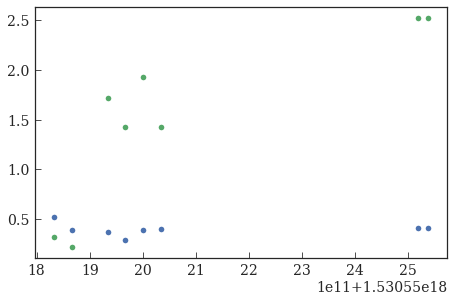

In [186]:
plt.plot(myDataFrame['Max amplitude X'],'o')
plt.plot(myDataFrame['Max amplitude Y'],'o')

In [187]:
# find optics values for BPM03
for k in range(len(optics.NAME)):
    name = optics.NAME[k]
    if name == 'PR.BPM03':
        print k

53


In [188]:
print(optics.NAME[53])
print(optics.BETA11[53])
print(optics.BETA22[53])
print(optics.ALFA11[53])
print(optics.ALFA22[53])

PR.BPM03
22.0259507
12.52720217
0.0040734
0.03566641


In [190]:
# expected blowup deltaE
def delta_E(deltaX):
    return ((1+optics.ALFA22[53]**2)/(2*optics.BETA22[53]))*(deltaX**2)

In [193]:
delta_E(1.51e-3)*myDataFrame['beta']*myDataFrame['gamma']

2018-07-02 17:17:12.700    2.067881e-07
2018-07-02 17:17:46.300    2.067881e-07
2018-07-02 17:18:53.500    2.067881e-07
2018-07-02 17:19:27.100    2.067881e-07
2018-07-02 17:20:00.700    2.067881e-07
2018-07-02 17:20:34.300    2.067881e-07
2018-07-02 17:28:37.900    2.067881e-07
2018-07-02 17:28:58.300    2.067881e-07
dtype: float64

In [123]:
delta_E(2.19e-3)

1.0887565410988587e-07

In [124]:
delta_E(4.667948e-3)

4.9464607397964617e-07